In [1]:
!gdown --id 1ei61F0BJdbK31DtoyBiZfhQ0piMAwy1M

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ei61F0BJdbK31DtoyBiZfhQ0piMAwy1M
To: /content/img_cls_scenes_classification.zip
100% 255M/255M [00:01<00:00, 169MB/s]


In [2]:
!unzip -q /content/img_cls_scenes_classification.zip

In [3]:
!mv /content/scenes_classification /content/data

In [4]:
import torch
import torch .nn as nn
import os
import numpy as np
import matplotlib . pyplot as plt
from PIL import Image
from torch.utils . data import Dataset , DataLoader
from sklearn.model_selection import train_test_split

In [5]:
root_dir = '/content/data'
train_dir = os. path . join (root_dir, 'train')
test_dir = os. path . join (root_dir, 'val')


# get Class Names
classes = {
    label_idx : class_name for label_idx, class_name in enumerate(sorted(os.listdir(train_dir)))
}
classes

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [6]:
X_train = []
y_train = []
X_test = []
y_test = []
for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if 'train' in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

In [7]:
seed = 0
val_size = 0.2
is_shuffle = True

# split train, validation, test set
X_train , X_val , y_train , y_val = train_test_split(
    X_train , y_train , test_size = val_size , random_state = seed , shuffle = is_shuffle
)

In [8]:
# define Dataset
class ScenesDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        label = self.labels[index]
        img = Image.open(img_path)
        img = img.convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.img_paths)

In [9]:
# define Preprocess Images: Transform
def transform_image(image, image_size=(224,224)):
    img = image.resize(image_size)
    img = np.array(img)[...,:3] # in data, some image has 4 channels, but we need only 3 channels
    img = torch.tensor(img).permute(2,0,1).float() # permute: (H,W,C) -> (C,H,W); C is number of channels
    norm_img = img / 255.0
    return norm_img

In [10]:
train_dataset = ScenesDataset(X_train, y_train, transform = transform_image)
val_dataset = ScenesDataset(X_val, y_val, transform = transform_image)
test_dataset = ScenesDataset(X_test, y_test, transform = transform_image)

In [11]:
# Define DataLoader
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [12]:
# Define Model: DenseNet
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x.clone().detach()
        out = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(out)))
        out = torch.cat([res, out], dim=1)
        return out

class DenseBlock(nn.Module):
    def __init__(self, in_channels, num_layers, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(Bottleneck(in_channels + i*growth_rate, growth_rate))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2*growth_rate, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(2*growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.dense_blocks = nn.ModuleList()
        in_channels = 2*growth_rate
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(DenseBlock(in_channels, num_layers, growth_rate))
            in_channels += num_layers*growth_rate
            if i != len(num_blocks)-1:
                out_channels = in_channels//2
                self.dense_blocks.append(nn.Sequential(
                    nn.BatchNorm2d(in_channels),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                ))
                in_channels = out_channels

        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool1(self.relu(self.bn1(out)))
        for layer in self.dense_blocks:
            out = layer(out)
        out = self.pool2(self.relu(self.bn2(out)))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [13]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DenseNet([6, 12, 24, 16], growth_rate=32, num_classes=n_classes).to(device)

In [14]:
# Define Training Parameters
lr = 1e-4
n_epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [15]:
# Define Evaluation
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    losses = []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            losses.append(loss.item())

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [16]:
# define Training
def fit(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        batch_train_losses = []
        model.train()

        for idx, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch: {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses

In [17]:
# Training
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, n_epochs, device)

Epoch: 1/50, Train Loss: 1.7074, Val Loss: 1.6401, Val Acc: 0.4122
Epoch: 2/50, Train Loss: 1.5883, Val Loss: 1.5561, Val Acc: 0.4385
Epoch: 3/50, Train Loss: 1.5129, Val Loss: 1.4903, Val Acc: 0.4838
Epoch: 4/50, Train Loss: 1.4585, Val Loss: 1.4394, Val Acc: 0.5094
Epoch: 5/50, Train Loss: 1.4155, Val Loss: 1.3980, Val Acc: 0.5262
Epoch: 6/50, Train Loss: 1.3807, Val Loss: 1.3655, Val Acc: 0.5315
Epoch: 7/50, Train Loss: 1.3533, Val Loss: 1.3412, Val Acc: 0.5347
Epoch: 8/50, Train Loss: 1.3288, Val Loss: 1.3192, Val Acc: 0.5444
Epoch: 9/50, Train Loss: 1.3093, Val Loss: 1.2937, Val Acc: 0.5454
Epoch: 10/50, Train Loss: 1.2897, Val Loss: 1.2855, Val Acc: 0.5525
Epoch: 11/50, Train Loss: 1.2720, Val Loss: 1.2639, Val Acc: 0.5629
Epoch: 12/50, Train Loss: 1.2542, Val Loss: 1.2464, Val Acc: 0.5664
Epoch: 13/50, Train Loss: 1.2414, Val Loss: 1.2372, Val Acc: 0.5732
Epoch: 14/50, Train Loss: 1.2302, Val Loss: 1.2236, Val Acc: 0.5736
Epoch: 15/50, Train Loss: 1.2165, Val Loss: 1.2109, Val A

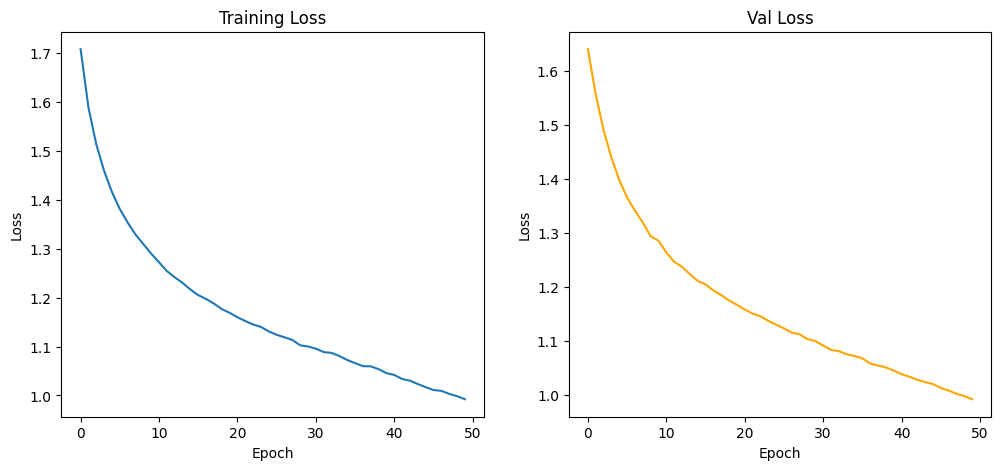

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [18]:
# Define Test
val_loss , val_acc = evaluate (model, val_loader, criterion, device)
test_loss , test_acc = evaluate (model, test_loader, criterion, device )

print ('Evaluation on val / test dataset')
print ('Val accuracy :', val_acc )
print ('Test accuracy :', test_acc)

Evaluation on val / test dataset
Val accuracy : 0.6359102244389028
Test accuracy : 0.64
Evaluation on val / test dataset
Val accuracy : 0.6359102244389028
Test accuracy : 0.64
